In [2]:
# Import Python libraries (use Python >= v. 3.9.0)
#-------------------------------------------------

import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import zipfile
import folium
import geojson
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
from pyrosm import OSM, get_data

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
from shapely.geometry import Point
from shapely.ops import cascaded_union

In [12]:
hospitals = pd.read_csv('cambridge_uni_hospital_sites.csv')
hospitals

,Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,Open Date,Close Date,Organisation Sub-Type Code,Parent Org Code
0,A6B3B,CUH AT MEADOWS COMMUNITY CENTRE,Y61,QUE,1 ST. CATHARINES ROAD,NaN,NaN,CAMBRIDGE,NaN,CB4 3XJ,20211001,NaN,NaN,RGT
1,A9J5N,CUH AT ROSMINI CENTRE,Y61,QUE,69A QUEENS ROAD,NaN,NaN,WISBECH,NaN,PE13 2PH,20220401,NaN,NaN,RGT
2,B1C9Z,CUH AT SPECSAVERS ROYSTON,Y61,QUE,27A-27B HIGH STREET,NaN,NaN,ROYSTON,NaN,SG8 9AA,20220401,NaN,NaN,RGT
3,B5D1I,CUH AT DODDINGTON HOSPITAL,Y61,QUE,BENWICK ROAD,DODDINGTON,NaN,MARCH,NaN,PE15 0UG,20210401,NaN,NaN,RGT
4,C5Z7J,CAMBRIDGE BIOMEDICAL RESEARCH CENTRE - VALNEVA...,Y61,QUE,HILLS ROAD,NaN,NaN,CAMBRIDGE,NaN,CB2 0QQ,20210401,NaN,NaN,RGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,RGT98,NUFFIELD HEALTH CAMBRIDGE HOSPITAL,Y61,QUE,4 TRUMPINGTON ROAD,NaN,NaN,CAMBRIDGE,CAMBRIDGESHIRE,CB2 8AF,20121001,NaN,NaN,RGT
174,RGT99,ST MARY'S SURGERY,Y61,QUE,37 ST. MARYS STREET,NaN,NaN,ELY,CAMBRIDGESHIRE,CB7 4HF,20121001,NaN,NaN,RGT
175,T4O3M,CUH AT COLCHESTER STARS,Y61,QUE,5A QUEEN STREET,NaN,NaN,COLCHESTER,NaN,CO1 2PG,20210401,NaN,NaN,RGT
176,T8C3T,CUH AT ROYAL PAPWORTH HOSPITAL,Y61,QUE,PAPWORTH ROAD,CAMBRIDGE BIOMEDICAL CAMPUS,NaN,CAMBRIDGE,NaN,CB2 0AY,20201001,NaN,NaN,RGT


/usr/local/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


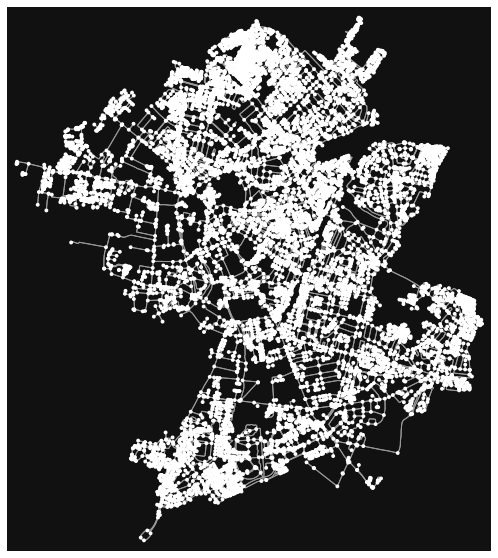

In [20]:

G = ox.graph.graph_from_place('Cambridge', simplify = True, network_type = 'walk')

# The following code can be run to decrease the time required to generate OSMnx network graphs.
# If a node cannot access at least 10% of other nodes it is removed from the network
#---------------------------------------------------------------------------------------

remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
     reach = len(nx.descendants(G, node))
     if reach < num_nodes / 10:
         remove_list.append(node)
for node in remove_list:
     G.remove_node(node)

#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));


In [74]:
total_nodes = len(list(G.nodes))
total_nodes

12844

In [27]:
#get the hospital details of 2 hospitals from the dataframe to compare location coverage scores with
hospital_t = hospitals.iloc[0]
hospital1_name = hospital_t['Name']
hospital1_address = hospital_t['Address Line 1'] + ', ' + 'Cambridge'
hospital1_geocode = ox.geocode(hospital1_address)
hospital1_node = ox.distance.get_nearest_node(G, hospital1_geocode)

hospital_s = hospitals.iloc[4]
hospital2_name = hospital_s['Name']
hospital2_address = hospital_s['Address Line 1'] + ', ' + 'Cambridge'
hospital2_geocode = ox.geocode(hospital2_address)
hospital2_node= ox.distance.get_nearest_node(G, hospital2_geocode)
#source_hospital = ox.distance.get_nearest_node(G_heartlands, [52.4786219775871, -1.8288765613718057])
print('the nearest node for hospital 1 is: {}'.format(hospital1_node))
print('the nearest node for hospital 2 is: {}'.format(hospital2_node))

the nearest node for hospital 1 is: 8613287131
the nearest node for hospital 2 is: 1486045382


/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [89]:
# Add freeflow travel time as an edge attribute to the networkx map
#---------------------------------------------------------------------------------------

#G = ox.add_edge_speeds(G) #---- This imputes free-flow travel speeds for all edges via the mean maxspeed value of the edges (speed limit of the street).
'''
G = ox.speed.add_edge_travel_times(G, precision=1) #---- This adds free flow travel time as an edge attribute

maps = [G_leicester, G_heartlands]

for G in maps: 
    for u, v, k, data in G.edges(data = True, keys = True):
        data['time'] = data['length']/(data['speed_kph'] * (1000/60))

'''

"\nG = ox.speed.add_edge_travel_times(G, precision=1) #---- This adds free flow travel time as an edge attribute\n\nmaps = [G_leicester, G_heartlands]\n\nfor G in maps: \n    for u, v, k, data in G.edges(data = True, keys = True):\n        data['time'] = data['length']/(data['speed_kph'] * (1000/60))\n\n"

/usr/local/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


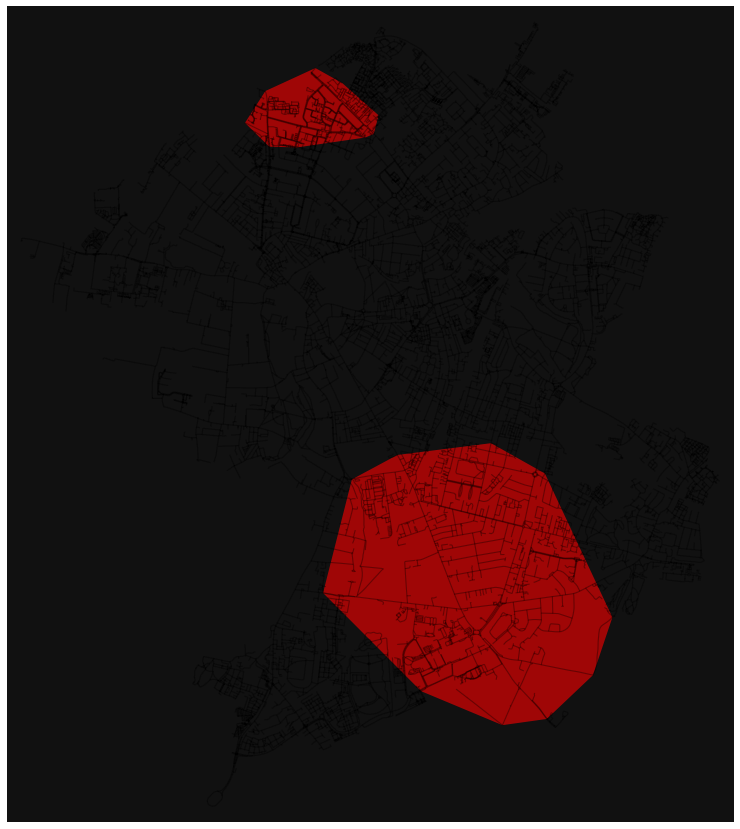

In [91]:
# Generate isochrone polygons for leicester
#--------------------------------------------------------------------------------------------------------------
isochrone_polys = []
all_nodes = []
trip_time = 20
locations = [hospital1_node, hospital2_node]
# Retrun one color for each isochrone (each of the trip times) 
#------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)
for point in locations:
    isochrone_polys_sub = []
    subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)] 
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)
    all_nodes.append(node_points)

# Plot the network then add isochrones as colored descartes polygon patches
#-----------------------------------------------------------------------
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
for polygon in isochrone_polys:
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc='Red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [97]:
# Color the nodes according to isochrone then plot the urban network graph
#--------------------------------------------------------------------------
subgraph1 = nx.ego_graph(G, hospital1_node, radius=trip_time, distance='time') #---- uses the edge attribute 'time' to define the isochrones for each of the trips
subgraph2 = nx.ego_graph(G, hospital2_node, radius=trip_time, distance='time') #---- uses the edge attribute 'time' to define the isochrones for each of the trips
nodes1 = len(list(subgraph1.nodes))
nodes1_proportion = round((nodes1/total_nodes)*100)
nodes2 = len(list(subgraph2.nodes))
nodes2_proportion = round((nodes2/total_nodes)*100)

print('The total number of nodes in the Cambridge area is: {}'.format(total_nodes))
print()
print ('The number of nodes covered by {} within a 20 minutes walk is: {} this is {}'.format(hospital1_name, nodes1, nodes1_proportion) + '% of all nodes')
print()
print ('The number of nodes covered by {} within a 20 minutes walk is: {} this is {}'.format(hospital2_name, nodes2, nodes2_proportion) + '% of all nodes')

The total number of nodes in the Cambridge area is: 12844

The number of nodes covered by CUH AT MEADOWS COMMUNITY CENTRE within a 20 minutes walk is: 566 this is 4% of all nodes

The number of nodes covered by CAMBRIDGE BIOMEDICAL RESEARCH CENTRE - VALNEVA COVID19 TRIALS within a 20 minutes walk is: 1025 this is 8% of all nodes
